# Goodbye Scatterplot, Welcome Binned Scatterplot

Link Original: https://github.com/matteocourthoud/Blog-Posts/blob/main/binscatter.ipynb

When we want to visualize the relationship between two continuous variables, the go-to plot is the **scatterplot**. It's a very intuitive visualization tool that allows us to directly look at the data. However, when we have a lot of data and/or when the data is skewed, scatterplots can be too noisy to be informative.

In this blog post, I am going to review a very powerful alternative to the scatterplot to visualize correlations between two variables: the **binned scatterplot**. Binned scatterplots are not only a great visualization tool, but they can also be used to do inference on the conditional distribution of the dependent variable.

## The Scatterplot

Let's start with an example. Suppose we are an **online marketplace** where multiple firms offer goods that consumer can efficiently browse, compare and buy. Our **dataset** consists in a snapshot of the firms active on the marketplace.  

Let's load the data and have a look at it. You can find the code for the data generating process [here](). 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_marketplace

df = dgp_marketplace().generate_data(N=10_000)
df.head()

,age,sales,online,products
0,0.312777,450.858091,0,2
1,1.176221,1121.882449,1,3
2,1.764048,2698.714549,0,1
3,1.082742,1627.746386,0,3
4,3.156503,1464.593939,0,2


We have information on 10.000 firms. For each firm we know:

- `age`: the age of the firm
- `sales`: the monthly sales from last month
- `online`: whether the firm is only active online
- `products`: the number of products that the firm offers

Suppose we are interested in understanding the relationship between `age` and `sales`. What is the **life-cycle** of sales?

Let's start with a simple **scatterplot** of `sales` over `age`.

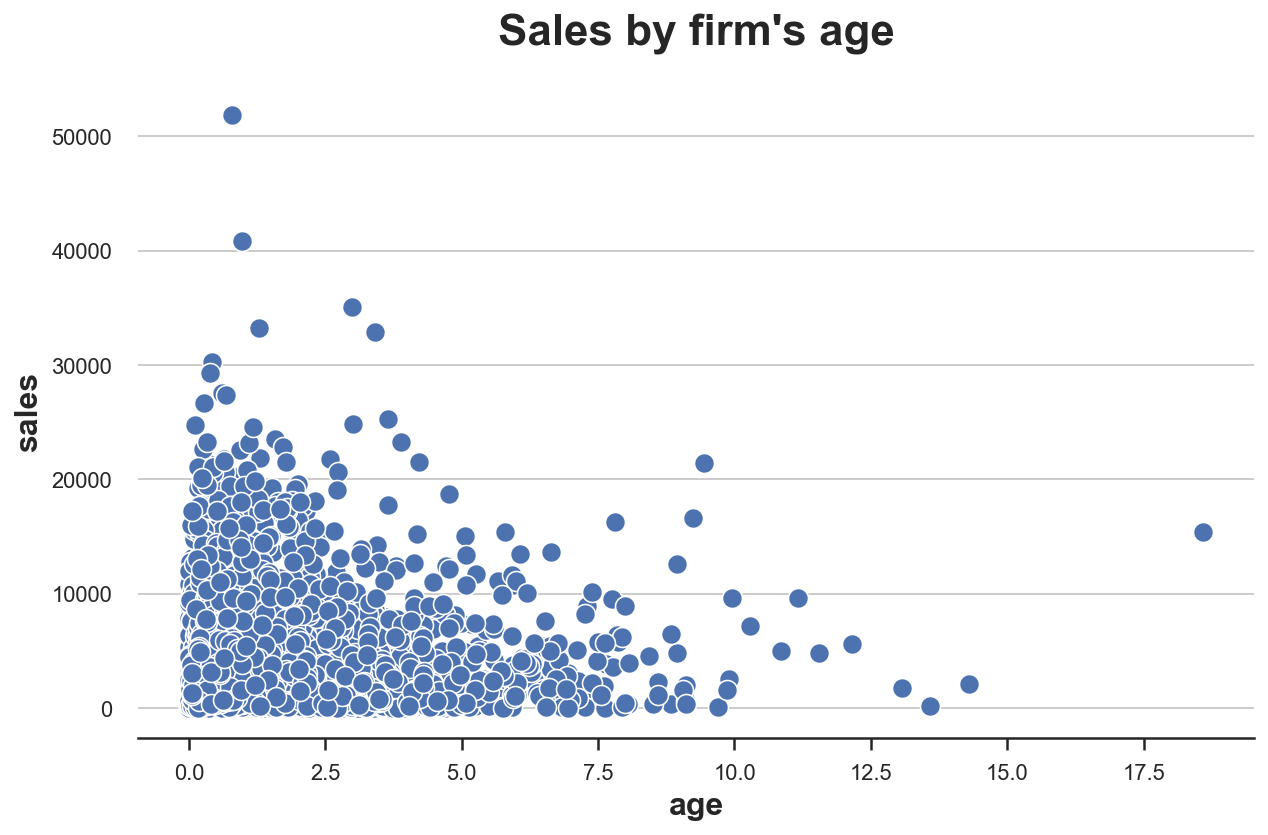

In [3]:
sns.scatterplot(x='age', y='sales', data=df);
plt.title("Sales by firm's age");

The plot is extremely **noisy**. We have a lot of observations, therefore, it is very difficult to visualize them all. If we had to guess, we could say that the relationship looks negative (`sales` decrease with `age`), but it would be a very uninformed guess.

We are now going to explore some plausible tweaks and alternatives.

## Scatterplot Alternatives

What can we do when we have an extremely dense scatterplot? One solution could be to plot the **density** of the observations, instead of the observations themselves. 

There are multiple solutions in Python to visualize the density of a 2-dimensional distribution. A very useful one is [seaborn](https://seaborn.pydata.org/) [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html). `jointplot` plots the joint distribution of two variables, together with the marginal distributions along the axis. The default option is the scatterplot, but one can also choose to add a regression line (`reg`), change the plot to a histogram (`hist`), a hexplot (`hex`), or a [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) (`kde`).

Let's try the **hexplot**, which is basically a histogram of the data, where the bins are hexagons, in the 2-dimensional space.

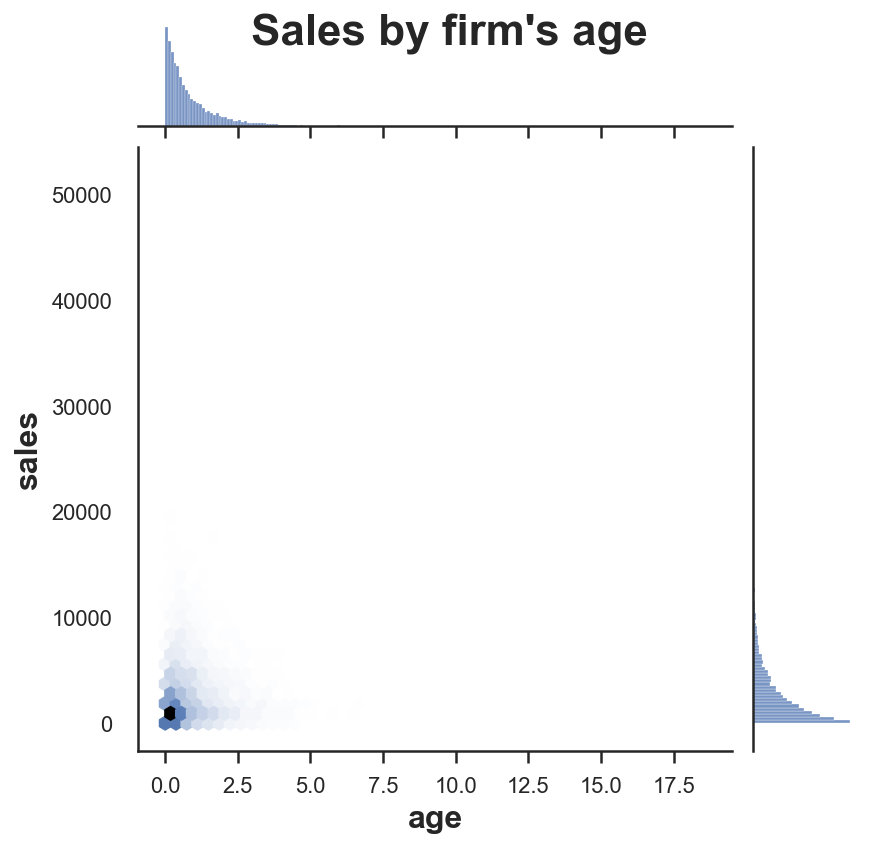

In [4]:
s = sns.jointplot(x='age', y='sales', data=df, kind='hex', );
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age");

Not much has changed. It looks like the distributions of `age` and `sales` are both very **skewed** and, therefore, most of the action is concentrated in a very small subspace.

Maybe we could remove **outliers** and zoom-in on the area where most of the data is located. Let's zoom-in on the bottom-left corner, on observations what have `age < 3` and `sales < 3000`.

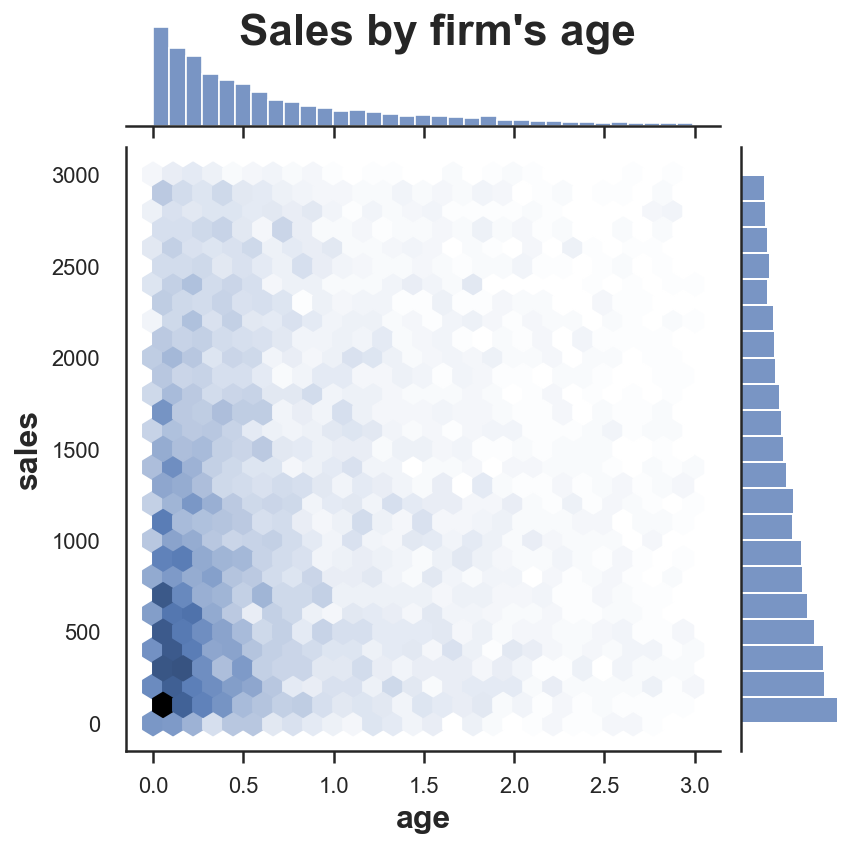

In [5]:
s = sns.jointplot(x='age', y='sales', data=df.query("age < 3 & sales < 3000"), kind="hex");
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age");

Now there is much less empty space, but it does not look like we are going far. The joint distribution is **still too skewed**. This is the case when the data follows some power distribution, as it's often the case with business data. 

One solution is to **transform** the variable, by taking the [**natural logarithm**](https://en.wikipedia.org/wiki/Natural_logarithm).

In [6]:
df['log_age'] = np.log(df['age'])
df['log_sales'] = np.log(df['sales'])

We can now plot the relationship between the logarithms of `age` and `sales`.

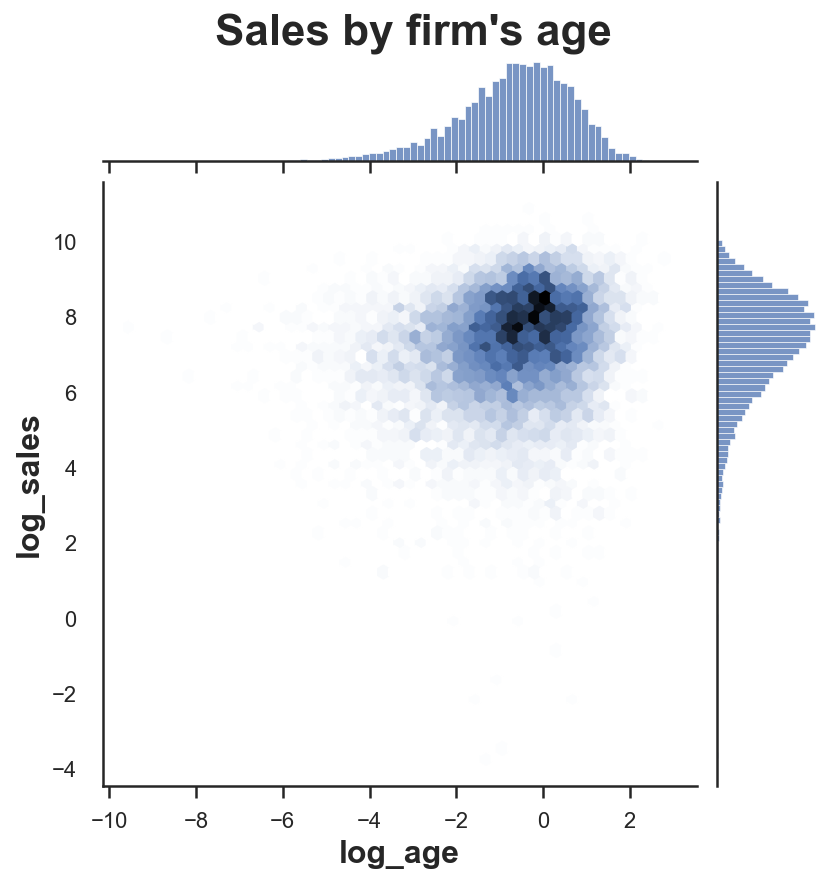

In [7]:
s = sns.jointplot(x='log_age', y='log_sales', data=df, kind='hex');
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age", y=1.02);

The logarithm definitely helped. Now the data is more spread across space, which means that the visualization is more informative. Moreover, it looks like there is **no relationship** between the two variables. 

However, there is still **too much noise**. Maybe data visualization alone is not sufficient do draw a conclusion.

Let's swap to a more structured approach: [**linear regression**](https://en.wikipedia.org/wiki/Linear_regression). Let's linearly regress `log_sales` on `log_age`.

In [8]:
smf.ols('log_sales ~ log_age', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.3971,0.015,478.948,0.000,7.367,7.427
log_age,0.1690,0.010,16.888,0.000,0.149,0.189


The regression coefficient for `log_age` is **positive** and statistically significant (i.e. different from zero). It seems that all previous visualizations were very **misleading**. From none of the graphs above we could have guessed such a strong positive relationship.

However, maybe this relationship is different for `online`-only firms and the rest of the sample. We need to control for this variable in order to avoid [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) and, more generally, bias.

With linear regression, we can **condition the analysis on covariates**. Let's add the binary indicator for `online`-only firms and the variable counting the number of `products` to the regression.

In [9]:
smf.ols('log_sales ~ log_age + online + products', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.5717,0.037,176.893,0.000,6.499,6.644
log_age,0.0807,0.010,7.782,0.000,0.060,0.101
online,0.1447,0.027,5.433,0.000,0.092,0.197
products,0.3456,0.014,24.110,0.000,0.317,0.374


The coefficient for `log_age` is still positive and statistically significant, but its **magnitude** has halved.

What should we conclude? It seems that `sales` increase over age, on average. However, this pattern might be very **non-linear**. 

Within the linear regression framework, one approach could be to **add extra terms** such as polynomials (`age^2`) or categorical features (e.g. `age < 2`). However, it would be really cool if there was a more **flexible** (i.e. [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics)) approach that could inform us on the relationship between firm `age` and `sales`.

If only...

## The Binned Scatterplot

The **binned scatterplot** is a very powerful tool that provides a **flexible** and **parsimonious** way of visualizing and summarizing conditional means (and not only) in large datasets.

The **idea** behind the binned scatterplot is to divide the conditioning variable, `age` in our example, into **equally sized bins or quantiles**, and then plot the conditional mean of the dependent variable, `sales` in our example, within each bin. 

### Details

[Cattaneo, Crump, Farrell, Feng (2021)](https://arxiv.org/abs/1902.09608) have built an extremely good package for binned scatterplots in R, [binsreg](https://cran.r-project.org/web/packages/binsreg/index.html). Moreover, they have ported the package to Python. We can install `binsreg` directly from pip using `pip install binsreg`. You can find more information on the Python package [here](https://pypi.org/project/binsreg/), while the original and detailed R package documentation can be found [here](https://www.rdocumentation.org/packages/binsreg/versions/0.7/topics/binsreg).

The most important choice when building a binned scatterplot is the **number of bins**. The trade-off is the usual [**bias-variance trade-off**](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). By picking a higher number of bins, we have more points in the graph. In the extreme, we end up having a standard **scatterplot** (assuming the conditioning variable is continuous). On the other hand, by decreasing the number bins, the plot will be more stable. However, in the extreme, we will have a **single point** representing the sample mean.

[Cattaneo, Crump, Farrell, Feng (2021)](https://arxiv.org/abs/1902.09608) prove that, in the basic binned scatterplot, the number of bins that minimizes the mean squared error is proportional to $n^{1/3}$, where $n$ is the number of observations. Therefore, in general, more observations lead to more bins.

[Starr and Goldfarb (2020)](https://onlinelibrary.wiley.com/doi/abs/10.1002/smj.3199) add the following consideration:

> "*However other elements are also important. For example, holding the distribution of x constant, the more curvilinear the true relationship between x and y is, the more bins the algorithm will select (otherwise mean squared error will increase). This implies that even with large n, few bins will be chosen for relatively flat relationships. The calculation of the optimal number of bins in a basic binned scatterplot thus takes into account the amount and location of variation in the data available to identify the relationship between x and y.*"

It is strongly recommended to use the default optimal number of bins. However, one can also set a customized number of bins in `binsreg` with the `nbins` option.

Binned scatterplots however, do not just compute conditional means, for optimally chosen intervals, but they can also provide **inference** for these means. In particular, we can build **confidence intervals** around each data point. In the `binsreg` package, the option `ci` adds confidence intervals to the estimation results. The option takes as input a tuple of parameters `(p, s)` and uses a piecewise polynomial of degree `p` with `s` smoothness constraints to construct the confidence intervals. By default, the confidence intervals are not included in the plot. For what concerns the choice of `p` and `s`, the [package documentation](https://www.rdocumentation.org/packages/binsreg/versions/0.7/topics/binsreg) reports:

> "*Recommended specification is ci=c(3,3), which adds confidence intervals based on cubic B-spline estimate of the regression function of interest to the binned scatter plot.*"

### Binsreg

One problem with the Python version of the package, is that is not very Python-ish. Therefore, I have wrapped the `binsreg` package into a function `binscatter` that takes care of cleaning and formatting the output in a nicely readable [Pandas](https://pandas.pydata.org/) DataFrame.

In [10]:
import binsreg

def binscatter(**kwargs):
    # Estimate binsreg
    est = binsreg.binsreg(**kwargs)
    
    # Retrieve estimates
    df_est = pd.concat([d.dots for d in est.data_plot])
    df_est = df_est.rename(columns={'x': kwargs.get("x"), 'fit': kwargs.get("y")})
    
    # Add confidence intervals
    if "ci" in kwargs:
        df_est = pd.merge(df_est, pd.concat([d.ci for d in est.data_plot]))
        df_est = df_est.drop(columns=['x'])
        df_est['ci'] = df_est['ci_r'] - df_est['ci_l']
    
    # Rename groups
    if "by" in kwargs:
        df_est['group'] = df_est['group'].astype(df[kwargs.get("by")].dtype)
        df_est = df_est.rename(columns={'group': kwargs.get("by")})

    return df_est

We can now proceed to **estimate** and **visualize** the binned scatterplot for `age` based on `sales`. 

In [11]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', data=df, ci=(3,3))
df_est.head()

,group,age,bin,isknot,mid,sales,ci_l,ci_r,ci
0,Full Sample,0.012556,0,0,0,1624.779616,1312.439124,1905.535412,593.096288
1,Full Sample,0.037015,1,0,0,1664.078013,1435.438411,1893.888819,458.450408
2,Full Sample,0.065813,2,0,0,1779.657894,1555.909281,1968.681960,412.772679
3,Full Sample,0.094486,3,0,0,1976.464837,1740.530049,2216.800005,476.269956
4,Full Sample,0.125363,4,0,0,2015.833752,1796.489393,2280.237320,483.747927


The `binscatter` function outputs a dataset in which, for each bin of the conditioning variable, `age`, we have values and confidence intervals for the outcome variable, `sales`.

We can now plot the estimates.

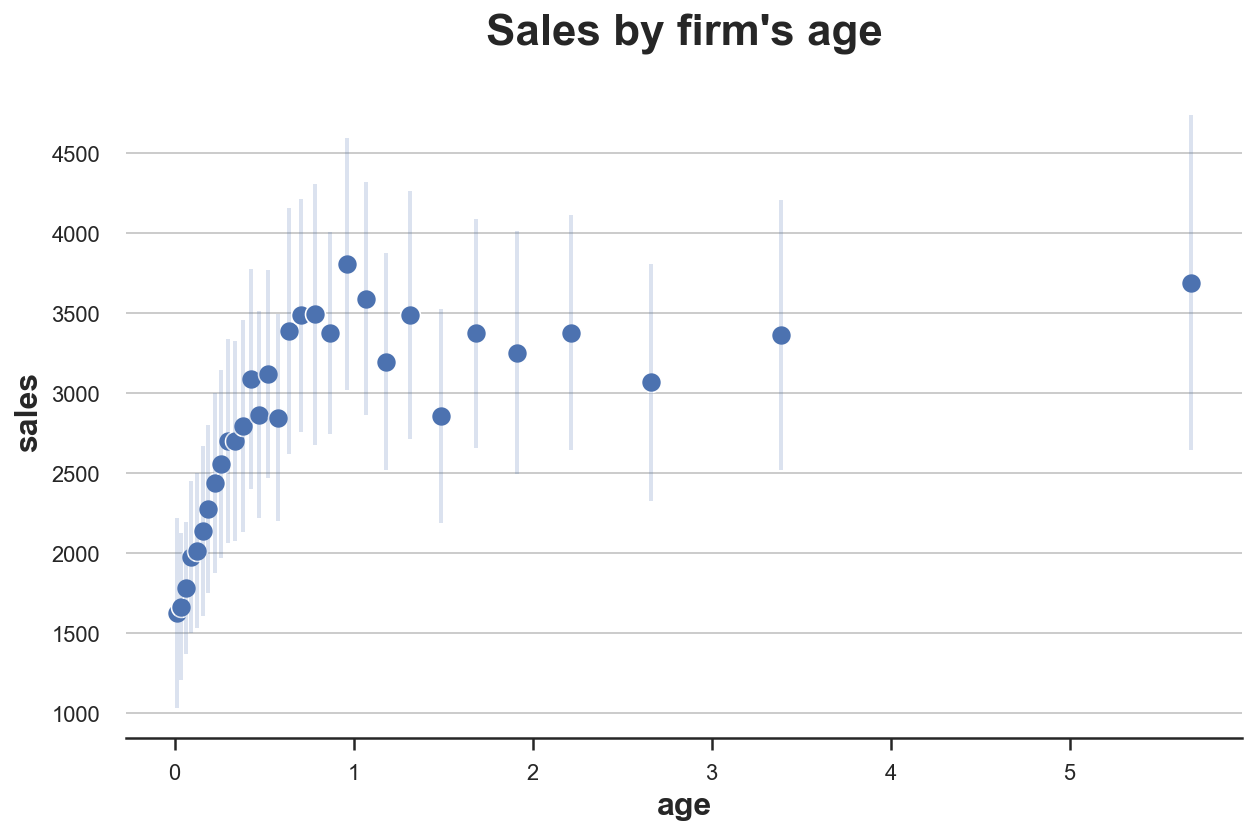

In [12]:
# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est);
plt.errorbar('age', 'sales', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

The plot is quite revealing. Now the relationship looks extremely **non-linear** with a sharp increase in `sales` at the beginning of the lifetime of a firm, followed by a plateau. 

Moreover, the plot is also telling us information regarding the distributions of `age` and `sales`. In fact, the plot is more dense on the left, where the distribution of `age` is concentrated. Also, confidence intervals are tighter on the left, where most of the conditional distribution of `sales` lies.

As we already discussed in the previous section, it might be important to control for other variables. For example, the number of `products`, since firms that sell more products probably survive longer in the markets and also make more sales. 

`binsreg` allows to **condition** the analysis on any number of variables, with the `w` option.

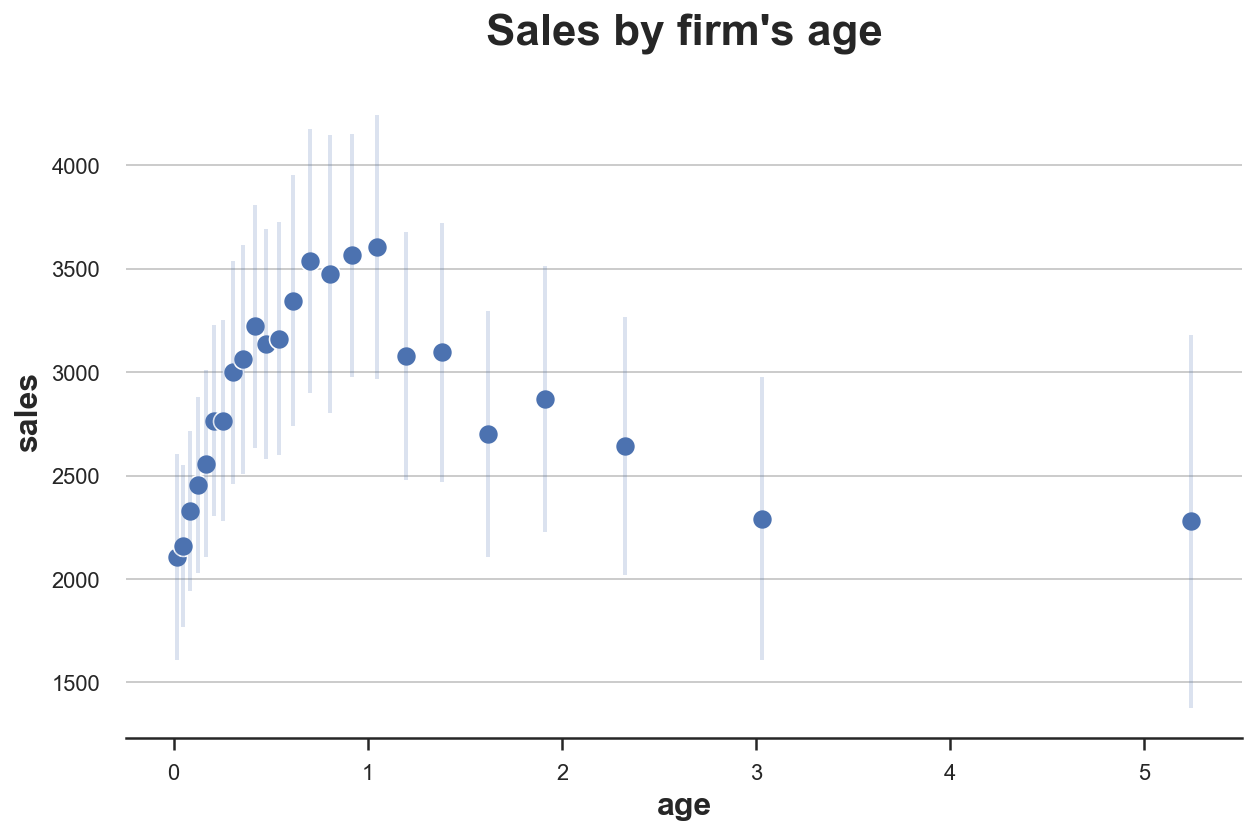

In [13]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', w=['products'], data=df, ci=(3,3))

# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est);
plt.errorbar('age', 'sales', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

Conditional on number of `products`, the shape of the `sales` life-cycle changes further. Now, after an initial increase in sales, we observe a gradual decrease over time.

Do `online`-only firms have different `sales` life-cycles with respect to mixed online-offline firms? We can produce different binned scatterplots **by group** using the option `by`.

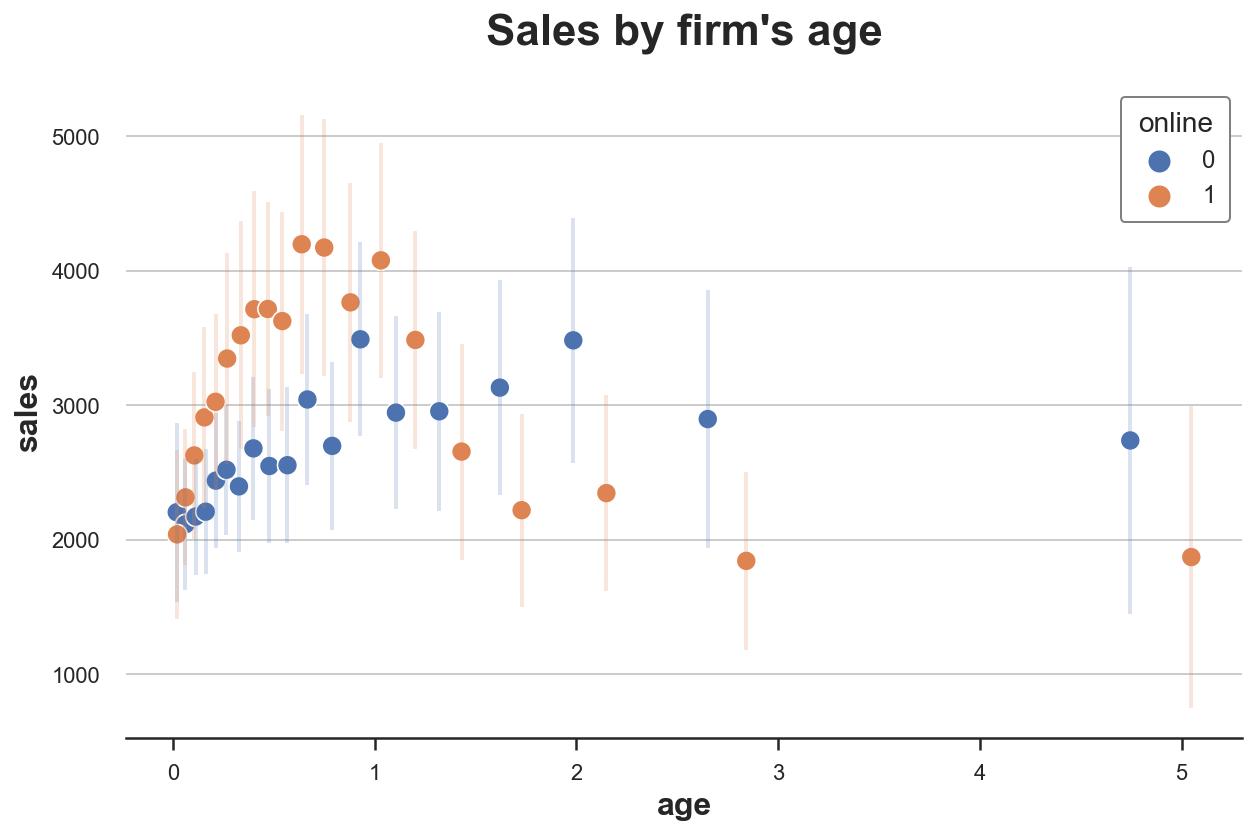

In [14]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', by='online', w=['products'], data=df, ci=(3,3))

# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est, hue='online');
plt.errorbar('age', 'sales', yerr='ci', data=df_est.query("online==0"), ls='', lw=2, alpha=0.2);
plt.errorbar('age', 'sales', yerr='ci', data=df_est.query("online==1"), ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

From the binned scatterplot, we can see that `online` products have on average shorter lifetimes, with a higher initial peak in `sales`, followed by a sharper decline.

## Conclusion

In this blog post, we have analyzed a very powerful data visualization tool: the **binned scatterplot**. In particular, we have seen how to use the `binsreg` package to automatically pick the optimal number of bins and perform non-parametric inference on conditional means. However, the `binsreg` package offers much more than that and I strongly recommend checking [its manual](https://cran.r-project.org/web/packages/binsreg/binsreg.pdf) more in depth.

## References

[1] E Starr, B Goldfarb, [Binned Scatterplots: A Simple Tool to Make Research Easier and Better](https://onlinelibrary.wiley.com/doi/abs/10.1002/smj.3199) (2020), Strategic Management Journal.

[2] M. D. Cattaneo, R. K. Crump, M. H. Farrell, Y. Feng, [On Binscatter](https://arxiv.org/abs/1902.09608) (2021), working paper.

[3] P. Goldsmith-Pinkham, [Lecture 6. Linear Regression II: Semiparametrics and Visualization](https://www.youtube.com/watch?v=fg9T2gPZCIs), Applied Metrics PhD Course.